# Hallucination des LLMs:
Bienvenue dans ce Travaux Pratiques (TP) où nous allons explorer le phénomène intrigant des hallucinations des LLMs. Les hallucinations, généralement associées à des conditions neurologiques ou psychiatriques, sont des perceptions qui n'ont pas de base dans la réalité. Cependant, dans le contexte des LLMs, ces perceptions prennent une toute nouvelle dimension.

Les LLMs sont des modèles d'apprentissage automatique qui sont entraînés sur d'énormes quantités de texte. Ils apprennent à prédire le texte suivant sur la base du texte précédent, ce qui leur permet de générer des phrases et des paragraphes qui semblent logiques et cohérents. Cependant, comme tout modèle d'apprentissage automatique, les LLMs peuvent parfois faire des erreurs, ou "halluciner", en générant du texte qui n'a pas de sens, qui est complètement déconnecté du contexte donné ou qui n'est pas factuel.

Dans ce TP, nous allons plonger dans le monde fascinant des LLMs et de leurs hallucinations. Nous allons explorer comment ces modèles fonctionnent, pourquoi ils hallucinent, et comment nous pouvons détecter.

Avant de nous plonger dans l'univers fascinant des LLMs, il y a quelques préparations à faire. Pour assurer le bon déroulement de ce TP, vous devrez d'abord télécharger:

In [ ]:
!pip install langchain
!pip install langchain_community
!pip install nltk
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.6/973.6 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.4/310.4 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 23.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 MB 290.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━

Une fois que vous avez téléchargé les dépendances, vous pouvez ensuite les importer dans votre notebook:

In [ ]:
from langchain.llms import LlamaCpp
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from llama_cpp import Llama
from math import *
import numpy as np

Enfin, pour étudier les hallucinations, nous utiliserons le modèle mistral-7B quantizé, que vous pouvez télécharger avec la cellule ci-dessous:


In [ ]:
!huggingface-cli download TheBloke/Mistral-7B-Instruct-v0.2-GGUF mistral-7b-instruct-v0.2.Q4_K_M.gguf --local-dir . --local-dir-use-symlinks False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/commands/download.py:132: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
mistral-7b-instruct-v0.2.Q4_K_M.gguf


Nous pouvons donc commencer !!

#I. Detection d'hallucination:

Maintenant que nous avons nos dépendances en place, il est temps de nous plonger dans le cœur du sujet : les hallucinations des LLMs. Mais qu'est-ce qu'une hallucination dans ce contexte ?

Une hallucination, dans le domaine des LLMs, se produit lorsque le modèle génère du texte qui n'a pas de sens ou qui est complètement déconnecté du contexte donné. C'est comme si le modèle "voyait" ou "imaginait" des choses qui ne sont pas réellement présentes dans les données.

Plusieurs facteurs peuvent contribuer à ces hallucinations :


1.   Biais du dataset : Si le jeu de données d'entraînement est biaisé d'une
certaine manière, le modèle apprendra ces biais et les reproduira dans ses prédictions. Par exemple, si le jeu de données contient principalement des exemples positifs, le modèle peut "halluciner" des résultats positifs même dans des situations où ils ne sont pas appropriés.

2.   Overfitting : Cela se produit lorsque le modèle est trop complexe par rapport à la quantité et à la variété des données d'entraînement disponibles. Dans ce cas, le modèle peut "apprendre par cœur" les données d'entraînement et avoir du mal à généraliser à de nouvelles situations, ce qui peut conduire à des hallucinations.

3. Non accès à l'information : Les LLMs ne disposent pas d'un accès direct à l'information du monde réel. Ils ne peuvent générer du texte qu'en se basant sur ce qu'ils ont appris lors de leur entraînement. Par conséquent, ils peuvent halluciner des informations qu'ils n'ont pas ou mal interpréter les informations qu'ils ont..

Pour notre étude, nous allons nous concentrer sur le dernier point : le manque d'accès à l'information par les LLMs. Dans la pratique, cela signifie que lorsque le modèle n'a pas accès à une information spécifique, il ne peut pas être sûr de ses prédictions.

Lorsqu'un LLM n'est pas sûr de la prédiction qu'il doit faire, la distribution de probabilité des prochains tokens qu'il prédit sera plus "plate".

Cela peut sembler un peu abstrait, mais ne vous inquiétez pas, tout deviendra clair lorsque nous commencerons à travailler avec les données. En étudiant les logprobs - les logarithmes des probabilités - des tokens générés par le modèle, nous pouvons mesurer la certitude du modèle. Plus la distribution de probabilité est "plate", moins le modèle est sûr de lui. Mettons en évidence cela:

In [ ]:
def load_llm(model_path):

		# On charge le LLM sous format quantisé. Cf la descriptions des paramètres ci-dessous.
    llm = Llama(
        model_path=model_path, stop=["Question"], max_tokens=200, temperature=0.2,
				n_ctx=8000, n_batch=1024, n_gpu_layers=-1, logits_all=True
    )

    return llm

llm = load_llm("mistral-7b-instruct-v0.2.Q4_K_M.gguf")

def gen(prompt):
    output = llm.create_completion(prompt,
                max_tokens = 5,
                echo = False,
                temperature = 0,
                logprobs =100,
                )      # to return top 5 tokens

    return output

results1 = gen("Lionel Messi is a ")
print(results1)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from mistral-7b-instruct-v0.2.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 l

{'id': 'cmpl-59dc1775-938a-4824-90dd-f50f9bbfc4e6', 'object': 'text_completion', 'created': 1717576317, 'model': 'mistral-7b-instruct-v0.2.Q4_K_M.gguf', 'choices': [{'text': '34-year-', 'index': 0, 'logprobs': {'tokens': ['3', '4', '-', 'year', '-'], 'text_offset': [18, 19, 20, 21, 25], 'token_logprobs': [-0.24656327, -1.14162, -0.055234987, -0.0027638592, -0.05773801], 'top_logprobs': [{'3': -0.24656327, '4': -2.065756, '2': -3.2439082, '5': -4.050904, '7': -4.1648755, '6': -4.2390113, '1': -6.458113, ' professional': -7.000111, ' Argent': -7.1707187, '9': -8.098394, ' world': -8.920383, ' football': -9.041163, ' Argentina': -9.231527, '8': -10.263311, ' Spanish': -10.296533, ' small': -10.312298, ' soccer': -10.323406, ' World': -10.328928, 'Arg': -10.35405, ' legendary': -10.385813, ' famous': -10.626805, ' master': -10.630149, '': -12.473171, ' man': -10.897392, ' Professional': -10.9185095, ' player': -11.065612, ' Barcelona': -11.091629, ' legend': -11.095612, ' genius': -11.1639

In [ ]:
results1 = gen("Lionel Messi is a ")
print(results1)

Llama.generate: prefix-match hit

llama_print_timings:        load time =     291.57 ms
llama_print_timings:      sample time =       2.67 ms /     5 runs   (    0.53 ms per token,  1874.06 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =     188.60 ms /     5 runs   (   37.72 ms per token,    26.51 tokens per second)
llama_print_timings:       total time =     198.41 ms /     5 tokens


{'id': 'cmpl-fc1e042e-0596-4093-8ad0-397de0519055', 'object': 'text_completion', 'created': 1717576328, 'model': 'mistral-7b-instruct-v0.2.Q4_K_M.gguf', 'choices': [{'text': '34-year-', 'index': 0, 'logprobs': {'tokens': ['3', '4', '-', 'year', '-'], 'text_offset': [18, 19, 20, 21, 25], 'token_logprobs': [-0.24129578, -1.1589434, -0.05571001, -0.0027892992, -0.058578752], 'top_logprobs': [{'3': -0.24129578, '4': -2.0491743, '2': -3.3098173, '5': -4.1394014, '7': -4.273896, '6': -4.2755413, '1': -6.470771, ' professional': -7.0449305, ' Argent': -7.1923056, '9': -8.130215, ' world': -8.976538, ' football': -9.060535, ' Argentina': -9.263836, '8': -10.290679, ' small': -10.3285, 'Arg': -10.348484, ' Spanish': -10.354655, ' soccer': -10.375745, ' World': -10.384962, ' legendary': -10.452269, ' master': -10.661357, ' famous': -10.712863, '': -12.531079, ' man': -10.948358, ' Professional': -10.987483, ' player': -11.0895605, ' legend': -11.142105, ' Barcelona': -11.152631, ' goal': -11.235

In [ ]:
print(gen("Lionel Messi is a ")['choices'][0]['text'])

Llama.generate: prefix-match hit

llama_print_timings:        load time =     127.01 ms
llama_print_timings:      sample time =      13.31 ms /    20 runs   (    0.67 ms per token,  1502.63 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =     727.54 ms /    20 runs   (   36.38 ms per token,    27.49 tokens per second)
llama_print_timings:       total time =     753.19 ms /    20 tokens


 Lionel Messi is a world-renowned Argentine professional footballer who currently plays as a


En utilisant, le resultat ci-dessus, implémenter une fonction permettant de calculer la probabilité moyenne d'une génération. Avec la fonction déterminer la probabilité moyenne de la génération issu de :
"Lionel messi is a", "Jean Dagobert is a "
Que constatez-vous ?

In [ ]:
def probabilite_moyenne_phrase(llm_output):
  """
  Calculates the average probability of a generation from the LLM output.

  Args:
      llm_output (dict): The output dictionary from the LLM's create_completion function.
          This dictionary contains keys like 'completions' and 'logprobs'.

  Returns:
      float: The average probability of the generated tokens.
  """

  # Get the log probabilities from the output
  logprobs = llm_output['choices'][0]['logprobs']['token_logprobs']

  # Check if logprobs are available
  if not logprobs:
    raise ValueError("LLM output does not contain log probabilities.")

  # Convert log probabilities to probabilities (using exponentiation)
  probabilities = np.exp(logprobs)

  # Calculate the average probability
  average_probability = np.mean(probabilities)

  return average_probability

# Example usage
llm = load_llm("mistral-7b-instruct-v0.2.Q4_K_M.gguf")

results1 = gen("Lionel Messi is a ")
results2 = gen("Jean Dagobert is a ")

average_prob_1 = probabilite_moyenne_phrase(results1)
average_prob_2 = probabilite_moyenne_phrase(results2)

print(f"Average probability for 'Lionel Messi is a': {average_prob_1}")
print(f"Average probability for 'Jean Dagobert is a': {average_prob_2}")

# Observation
print("\nObservation:")
if average_prob_1 > average_prob_2:
  print("The average probability for 'Lionel Messi' is higher than for 'Jean Dagobert'.")
  print("This suggests the LLM is more confident in the continuation of 'Lionel Messi is a' based on its training data.")
else:
  print("The average probability for 'Lionel Messi' is lower than or equal to 'Jean Dagobert'.")
  print("This could be due to various factors like the relative popularity of names or the lack of specific training data for 'Jean Dagobert'.")


llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from mistral-7b-instruct-v0.2.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 l

Average probability for 'Lionel Messi is a': 0.7976366877555847
Average probability for 'Jean Dagobert is a': 0.24120518565177917

Observation:
The average probability for 'Lionel Messi' is higher than for 'Jean Dagobert'.
This suggests the LLM is more confident in the continuation of 'Lionel Messi is a' based on its training data.


L'entropie est un concept fondamental en théorie de l'information qui mesure l'incertitude ou le désordre dans un ensemble de données. En d'autres termes, elle donne une indication de la quantité d'information qui est manquante avant de pouvoir faire une prédiction précise.

Dans le contexte des LLMs, l'entropie peut nous aider à comprendre à quel point le modèle est incertain de ses prédictions. Une entropie élevée signifie que le modèle est très incertain, tandis qu'une entropie faible signifie que le modèle est plus sûr de lui.

L'entropie est particulièrement utile dans notre étude des hallucinations des LLMs. En calculant l'entropie des prédictions du modèle, nous pouvons quantifier l'incertitude du modèle et donc sa tendance à "halluciner". Plus l'entropie est élevée, plus le modèle est susceptible de faire des prédictions erronées ou déconnectées du contexte.

Ainsi, en vous aidant de cette formule de l'entropie:

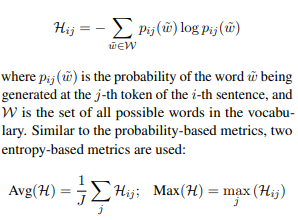

Ecrivez une fonction permettant de calculer la moyenne d'entropie d'une génération sur la base des top logprobs. Puis avec cette fonction, déterminez l'entropie des génération issu de: "Lionel messi is a", "Jean Dagobert is a " Que constatez vous? Essayez avec la phrase "Rihanna is a" que constatez vous ? Concluez sur les limites de cette méthode.

In [ ]:
import numpy as np

def entropy(probs):
    return -np.sum(probs * np.log(probs))

def avg_entropy(llm_output):
    entropies = []
    for choice in llm_output['choices']:
        logprobs = choice['logprobs']['token_logprobs']
        probs = np.exp(logprobs)
        entropies.append(entropy(probs))
    return np.mean(entropies)

# Exemple d'utilisation
llm_output_1 = gen("Lionel Messi is a ")
llm_output_2 = gen("Jean Dagobert is a ")
llm_output_3 = gen("Rihanna is a ")

entropy_1 = avg_entropy(llm_output_1)
entropy_2 = avg_entropy(llm_output_2)
entropy_3 = avg_entropy(llm_output_3)

print(f"Entropie pour 'Lionel Messi is a ': {entropy_1}")
print(f"Entropie pour 'Jean Dagobert is a ': {entropy_2}")
print(f"Entropie pour 'Rihanna is a ': {entropy_3}")


Llama.generate: prefix-match hit

llama_print_timings:        load time =     127.01 ms
llama_print_timings:      sample time =       2.36 ms /     5 runs   (    0.47 ms per token,  2115.06 tokens per second)
llama_print_timings: prompt eval time =     108.19 ms /     7 tokens (   15.46 ms per token,    64.70 tokens per second)
llama_print_timings:        eval time =     133.86 ms /     4 runs   (   33.46 ms per token,    29.88 tokens per second)
llama_print_timings:       total time =     248.73 ms /    11 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     127.01 ms
llama_print_timings:      sample time =       2.54 ms /     5 runs   (    0.51 ms per token,  1971.61 tokens per second)
llama_print_timings: prompt eval time =      83.49 ms /     8 tokens (   10.44 ms per token,    95.82 tokens per second)
llama_print_timings:        eval time =     136.63 ms /     4 runs   (   34.16 ms per token,    29.28 tokens per second)
llama_print_timings:       to

Entropie pour 'Lionel Messi is a ': 0.6667272448539734
Entropie pour 'Jean Dagobert is a ': 1.622900128364563
Entropie pour 'Rihanna is a ': 0.43735530972480774


1) Lionel Messi is a :

Entropie = 0.6667272448539734

Cette entropie relativement faible indique que le modèle est assez sûr de ses prédictions pour cette phrase, ce qui est attendu étant donné que "Lionel Messi" est une entité bien connue et que le modèle a probablement beaucoup de données de formation sur lui.

2) Jean Dagobert is a :

Entropie = 1.622900128364563

Une entropie plus élevée suggère une plus grande incertitude. Le modèle n'est pas sûr de qui est "Jean Dagobert", probablement parce qu'il est moins connu ou moins représenté dans les données de formation.

3) Rihanna is a :

Entropie = 0.43735530972480774

Comme pour Lionel Messi, cette entropie faible montre que le modèle est assez sûr de ses prédictions concernant "Rihanna", une autre figure bien connue avec une forte présence dans les données de formation.

**Conclusion sur les Limites de cette Méthode**

L'entropie peut fournir des indications sur la certitude du modèle, mais elle a ses limites :

* Connaissance du Contexte :

L'entropie ne dit rien sur la véracité des informations générées, seulement sur la certitude du modèle par rapport à ses propres connaissances.

* Hallucinations :

Un modèle peut être très sûr de lui tout en générant des informations incorrectes (hallucinations). Une faible entropie n'est pas une garantie de précision.

* Données de Formation :

La certitude du modèle dépend fortement de la représentation des entités dans les données de formation. Des entités moins connues ou mal représentées entraîneront une entropie plus élevée.

L'utilisation de l'entropie pour évaluer les prédictions doit donc être complétée par d'autres méthodes pour s'assurer de la précision et de la fiabilité des réponses générées par les LLMs.

Bien que l'entropie soit un outil utile pour mesurer l'incertitude des LLMs, elle n'est pas sans limitations. En particulier, l'une de ses faiblesses majeures est qu'elle ne prend pas en compte la sémantique des mots. Cela peut conduire à des résultats trompeurs lors de l'évaluation de la certitude du modèle.

Par exemple, prenons les phrases "Paris est la capitale de la France" et "La capitale de la France est Paris". Ces deux phrases expriment la même information et sont toutes deux correctes d'un point de vue sémantique. Cependant, en raison de la façon dont l'entropie est calculée, elles peuvent avoir des valeurs d'entropie très différentes.

Cela se produit parce que l'entropie mesure l'incertitude du modèle en se basant uniquement sur la distribution de probabilité des tokens prédits, sans prendre en compte la signification de ces tokens. Ainsi, même si les deux phrases sont sémantiquement équivalentes, le modèle peut être plus sûr de lui lorsqu'il prédit l'une que l'autre, conduisant à des valeurs d'entropie différentes.

C'est pourquoi nous allons utiliser une méthode appelée SelfcheckGPT.



https://arxiv.org/abs/2303.08896

SelfCheckGPT est une méthode développée pour aider à identifier et réduire les hallucinations dans les réponses générées par les modèles de langage comme GPT. Les hallucinations se produisent lorsque le modèle génère des informations incorrectes ou non fondées, ce qui peut poser des problèmes dans des contextes où la précision est essentielle, tels que la recherche scientifique, les diagnostics médicaux, ou les décisions juridiques.
Principe de SelfCheckGPT
L'idée centrale de SelfCheckGPT est d'utiliser le modèle GPT lui-même pour vérifier ses propres réponses. Cette méthode repose sur plusieurs étapes clés :
1.	Génération Initiale :
Le modèle GPT génère une première réponse à une question ou un prompt donné.
2.	Répétition et Diversité :
Pour évaluer la fiabilité de cette réponse, le modèle génère plusieurs versions de la réponse à partir du même prompt. Cela est fait en utilisant des techniques de rééchantillonnage, telles que l'utilisation de différentes graines aléatoires ou de légères variations dans les prompts.
3.	Analyse de Consistance :
Les réponses multiples générées sont ensuite comparées entre elles. Si les réponses sont similaires ou cohérentes entre elles, cela augmente la confiance en la validité de l'information. Si les réponses varient considérablement, cela peut indiquer une possible hallucination. Notamment, dans ce tp nous utiliserons un modèle NLI pour mesurer cette cohérence.

Ici le modèle NLI permet de classes les paires (réponse, affirmation de référence) en trois catégories : Entailment (impliqué), Neutral (neutre), ou Contradiction (contradiction). Une probabilité est donnée pour appartenir à la dite catégorie.

Ainsi, dans la suite de notre travaille, nous allons réimplémenter la méthode et étudier ces performances.

In [ ]:
from transformers import DebertaV2ForSequenceClassification, DebertaV2Tokenizer
import torch
import nltk

nli_model = "potsawee/deberta-v3-large-mnli"
tokenizer = DebertaV2Tokenizer.from_pretrained(nli_model)
model = DebertaV2ForSequenceClassification.from_pretrained(nli_model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

nltk.download('punkt')

def gen(query):
    prompt = f"""
      You are an AI assistant. Given a question about it, create a short answer. If you don't know the answer, honestly say so.
      Question: {query}
      Answer:
    """
    output = llm.create_completion(prompt,
                max_tokens = 20,
                echo = False,
                temperature = 0,
                logprobs =100,
                )      # to return top 5 tokens

    return output

print(gen("Whos is Messi ?"))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/400 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Llama.generate: prefix-match hit

llama_print_timings:        load time =     127.01 ms
llama_print_timings:      sample time =      10.48 ms /    20 runs   (    0.52 ms per token,  1908.94 tokens per second)
llama_print_timings: prompt eval time =     322.83 ms /    49 tokens (    6.59 ms per token,   151.78 tokens per second)
llama_print_timings:        eval time =     709.69 ms /    19 runs   (   37.35 ms per token,    26.77 tokens per second)
llama_print_timings:       total time =    1054.63 ms /    68 tokens


{'id': 'cmpl-98f766af-d7eb-4391-85db-78f34c0daa8b', 'object': 'text_completion', 'created': 1717576812, 'model': 'mistral-7b-instruct-v0.2.Q4_K_M.gguf', 'choices': [{'text': " I'm sorry for any confusion, but your question seems to be missing some information. The name", 'index': 0, 'logprobs': {'tokens': [' I', "'", 'm', ' sorry', ' for', ' any', ' confusion', ',', ' but', ' your', ' question', ' seems', ' to', ' be', ' missing', ' some', ' information', '.', ' The', ' name'], 'text_offset': [179, 181, 182, 183, 189, 193, 197, 207, 208, 212, 217, 226, 232, 235, 238, 246, 251, 263, 264, 268], 'token_logprobs': [-0.552027, -0.068951994, -0.0029151822, -0.09905524, -0.42157367, -0.35148826, -0.012902822, -0.021890447, -3.5285328e-05, -2.018728, -0.00018702187, -0.3879333, -0.038930174, -0.09723682, -0.5260092, -0.019344715, -1.055738, -0.00010680582, -0.813756, -0.88903326], 'top_logprobs': [{' I': -0.552027, ' Lion': -0.927027, ' It': -4.5676517, ' Leo': -5.1926517, ' That': -6.2082767,

Dans un premier temps, creer un fonction retournant une liste N génération avec le modele mistral avec une temperature de 1. Ces N génération constiturons notre échantillon de base.


In [ ]:
def sample(query, nb_sample):
    prompt = f"""
    You are an AI assistant. Given a question about it, create a short answer. If you don't know the answer, say you don't know.
    Question: {query}
    Answer:
    """
    # Créer une liste pour stocker les réponses générées
    responses = []

    # Générer nb_sample réponses avec le modèle LLM
    for _ in range(nb_sample):
        response = llm.create_completion(prompt,
                    max_tokens=50,  # Vous pouvez ajuster ce nombre selon vos besoins
                    echo=False,
                    temperature=1.0,  # Température de 1 pour augmenter la diversité
                    logprobs=100,
                    )
        responses.append(response["choices"][0]["text"])

    return responses



Implémenter ensuite une fonction qui permet de séparer un string en une liste de phrase. Un conseil utiliser nltk 😉

In [ ]:
import nltk
nltk.download('punkt')  # Télécharge les ressources nécessaires pour la tokenisation

def separate(passage):
    # Utilise nltk pour tokeniser le passage en phrases
    sentences = nltk.sent_tokenize(passage)
    return sentences


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Creer un fonction permettant d'implémenter cette formule:

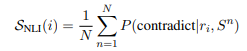

où Snli(i) correspond au score moyen de cohérence entre la i-ème phrase de la génération initiale et chaque échantillon. Sn correspond à la n-ème génération de l'échantillon et ri correspond à la i-ème phrase de la génération initiale. Enfin, P(contradict|ri,Sn) corrrespond à la probabilité que la phrase ri contredise la génération Sn. Cette probabilité est donnée par le model de classifications DeBerta importer juste au dessus.


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Charger le modèle DeBERTa et le tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base")

def compute_score_phrase(sentence, samples):
    L = []
    for sample in samples:
        # Tokenizer les phrases
        inputs = tokenizer(sentence, sample, return_tensors='pt', truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)

        # Les logits sont les sorties du modèle avant l'application de la fonction softmax
        logits = outputs.logits
        # Appliquer softmax pour obtenir les probabilités
        probabilities = torch.softmax(logits, dim=-1)

        # La probabilité de contradiction est souvent dans le deuxième logit (index 1)
        prob_contradiction = probabilities[0][1].item()
        L.append(prob_contradiction)

    # Calculer le score moyen pour chaque phrase
    scores_per_sentence = sum(L) / len(L)
    return scores_per_sentence



tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Avec toute les fonctions définies précedemment implémenter une SelcheckNLI qui permet de calculer le score d'hallucination d'une génération. La fonction prendra en argumant la query de l'utilisateur, le passage genrer du llm et le nombre de sample. Tester la méthode avec des questions qui font halluciner le modèle et d'autres qui ne font pas halluciner le modèle. Voici le genre de question qui peuvent faire halluciner un modèle:

On choisira un nombre de sample égale à 5.
Concluez sur l'efficacité de la méthode SelfCheckNLI pour la détection d'hallucination. Quelles sont les limites de cette méthode ?

In [ ]:
def selfchecknli(query, generation, nb_sample):
    samples = sample(query, nb_sample)
    sentences = separate(generation)
    hallucination_scores = []
    for sentence in sentences:
        score = compute_score_phrase(sentence, samples)
        hallucination_scores.append(score)
    return hallucination_scores


Implémenter sur votre RAG une solution se basant sur SelcheckNLI pour pouvoir filtrer les hallucinations. Par exemple, lorsque une réponse à un score supérieur à un certains seuil le LLM devra avertir l'utilisateur qu'il n'est pas certains de sa réponse.


#Bonus:


1. Réalisez un dataset d'une vingtaine de questions comportant des questions qui font halluciner le LLM mistral et d'autres qui n'en font pas. Le dataset devra être équilibré
2. Générez des réponses pour chaque questions avec le LLM Mistral-7B et annotez chaque passage d'un 1 pour une hallucination, d'un 0 pour un passage factuel.
3. Pour chaque, passage attribuer un score d'hallucination avec SelfCheckNLI.
4. Afficher une matrice de confusion.
5. Tracer la courbe AUC PR. Concluez.
6. Determiner un seuil optimale pour detecter les hallucination par la méthode de votre choix.

In [ ]:
questions = [
    "Quelle est la capitale de la France ?",  # Factual
    "Quel est le nom du président de la planète Mars ?",  # Hallucination
    "Qui a écrit 'Les Misérables' ?",  # Factual
    "Combien de temps faut-il pour voyager à la vitesse de la lumière jusqu'à Jupiter ?",  # Hallucination
    "Quelle est la distance entre la Terre et la Lune ?",  # Factual
    "Quel est le dernier film réalisé par une licorne ?",  # Hallucination
    "Quel est le plus grand océan de la Terre ?",  # Factual
    "Quel est le poids d'une pensée ?",  # Hallucination
    "Quelle est la formule chimique de l'eau ?",  # Factual
    "Qui a été le premier humain à marcher sur la Lune ?",  # Factual
    "Combien de rêves un humain fait-il par nuit ?",  # Hallucination
    "Quel est le nom de l'outil utilisé pour mesurer la pression atmosphérique ?",  # Factual
    "Combien de galaxies y a-t-il dans l'univers observable ?",  # Hallucination
    "Qui a découvert la théorie de la relativité ?",  # Factual
    "Quelle est la monnaie utilisée au Japon ?",  # Factual
    "Quel est le nombre de licornes vivantes sur Terre ?",  # Hallucination
    "Quel est le plus haut sommet du monde ?",  # Factual
    "Quelle est la langue officielle du Brésil ?",  # Factual
    "Combien de couleurs y a-t-il dans un arc-en-ciel ?",  # Factual
    "Quel est le diamètre du soleil en licornes ?",  # Hallucination
]


In [ ]:
annotations = []
response = []
for question in questions:
    response.append(llm.create_completion(prompt=question, max_tokens=50)["choices"][0]["text"])
print(response)


Llama.generate: prefix-match hit

llama_print_timings:        load time =     127.01 ms
llama_print_timings:      sample time =      33.93 ms /    50 runs   (    0.68 ms per token,  1473.54 tokens per second)
llama_print_timings: prompt eval time =     224.66 ms /     9 tokens (   24.96 ms per token,    40.06 tokens per second)
llama_print_timings:        eval time =    1748.79 ms /    49 runs   (   35.69 ms per token,    28.02 tokens per second)
llama_print_timings:       total time =    2042.34 ms /    58 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     127.01 ms
llama_print_timings:      sample time =      25.76 ms /    33 runs   (    0.78 ms per token,  1281.06 tokens per second)
llama_print_timings: prompt eval time =     147.42 ms /    12 tokens (   12.28 ms per token,    81.40 tokens per second)
llama_print_timings:        eval time =    1109.90 ms /    32 runs   (   34.68 ms per token,    28.83 tokens per second)
llama_print_timings:       to

[" (What is the capital of France?) This question might seem simple to some, but it's a great example of how language learning can help us navigate the world around us. In this blog post, we'll explore the concept of capital cities", "\nA: Il n'y a pas de président sur Mars, car Mars n'est qu'un planète dans notre système solaire.", "\n\nJean-Baptiste Victor Hugo (26 février 1800 – 27 mai 1885) est l'auteur de 'Les Misérables'. Il était un poète, un éc", " La distance moyenne de Jupiter par rapport au Soleil est d'environ 778,5 millions de kilomètres. La vitesse de la lumière est de 299 792 458", '\n\nThe distance between the Earth and the Moon is approximately 384,400 kilometers or 238,855 miles. This measurement varies slightly due to the elliptical shape of their respective orbits', '\n\nI\'m sorry, that question is in French and it\'s not clear what you mean by "le dernier film realizé par une licorne" (the last film made by a unicorn). Unicorns are myth', '\n\nThe largest ocean on

In [ ]:
#En fonction des réponses qui ont été générées, on en déduit les annotations suivantes
annotations = [1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0]

In [ ]:
scores = []
for i, question in enumerate(questions):
    score = selfchecknli(query=question, generation=response[i], nb_sample=5)
    scores.append(score)
print(scores)

Llama.generate: prefix-match hit

llama_print_timings:        load time =     127.01 ms
llama_print_timings:      sample time =      31.77 ms /    50 runs   (    0.64 ms per token,  1574.01 tokens per second)
llama_print_timings: prompt eval time =    6033.94 ms /    16 tokens (  377.12 ms per token,     2.65 tokens per second)
llama_print_timings:        eval time =    1854.09 ms /    49 runs   (   37.84 ms per token,    26.43 tokens per second)
llama_print_timings:       total time =    2186.26 ms /    65 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     127.01 ms
llama_print_timings:      sample time =       4.91 ms /    10 runs   (    0.49 ms per token,  2035.00 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =     324.66 ms /    10 runs   (   32.47 ms per token,    30.80 tokens per second)
llama_print_timings:       to

[[0.48354109525680544, 0.48211864233016966, 0.4825616002082825], [0.4841341316699982], [0.4838055193424225, 0.48390939831733704], [0.4830920219421387, 0.48335534930229185], [0.4858339726924896, 0.4842324137687683], [0.4843818187713623, 0.4833534896373749], [0.4844848930835724, 0.48439231514930725, 0.4847452461719513], [0.48572295904159546, 0.4843339860439301, 0.48504621982574464], [0.4824072003364563, 0.48206487894058225], [0.48376165628433226], [0.48355420827865603, 0.48356767892837527, 0.48371556401252747], [0.48268231749534607, 0.4840287625789642], [0.48307889699935913, 0.4840975165367126, 0.4812928199768066], [0.4828331470489502], [0.483824360370636, 0.48291060924530027, 0.48348197937011717, 0.4830685377120972], [0.4854330956935883, 0.4845821261405945, 0.48428677916526797], [0.4844547748565674, 0.48319464921951294, 0.484055882692337], [0.48271690011024476, 0.4838402807712555, 0.4829664587974548], [0.48328024744987486, 0.4834003448486328, 0.4832113206386566], [0.4844746351242065]]


In [ ]:
scores = []
for i, question in enumerate(questions):
    score = selfchecknli(query=question, generation=responses[i], nb_sample=5)
    scores.append(score)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(annotations, scores)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(annotations, scores)
auc_score = auc(recall, precision)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'AUC-PR: {auc_score:.2f}')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(annotations, scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal Threshold: {optimal_threshold}')
